## Capstone Project 2

_______________________________

### Predicting reorders - which previously purchased products will be in a Instacart user’s next order

____________________________


*“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 27 August 2019*

______________________________________

--------------------------------------

The following preliminary exploratory analysis is carried out

 - [x] Which day has the most orders? 
 - [x] What time of the day are most orders placed? 
 - [x] Lull period (between reorders) - frequency of reorder  
 - [x] Which department do most reorders belong to? 
 - [x] Which aisle do most reorders belong to ? 
 - [x] Average number of items in a reorder 
 - Which customers have most reorders
 - [x] Number of organic products in reorders
 - [x] Most reordered products
 - Frequency(of ordering) of top reordered products
 - Frequency (of ordering) of top reordered departments/aisles
 - Reorder ratio by Department
 - Reorder ratio by Aisle
 



>## File descriptions

>Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

>### aisles.csv

```
 aisle_id,aisle  
 1,prepared soups salads  
 2,specialty cheeses  
 3,energy granola bars  
 ...

```

>### departments.csv

```
 department_id,department  
 1,frozen  
 2,other  
 3,bakery  
 ...

```

>### order_products__*.csv

>These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items.

>```
 order_id,product_id,add_to_cart_order,reordered  
 1,49302,1,1  
 1,11109,2,1  
 1,10246,3,0  
 ... 

>```

>### orders.csv

>This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

>```
 order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
 2539329,1,prior,1,2,08,  
 2398795,1,prior,2,3,07,15.0  
 473747,1,prior,3,3,12,21.0  
 ...

>```

>### products.csv

>```
 product_id,product_name,aisle_id,department_id
 1,Chocolate Sandwich Cookies,61,19  
 2,All-Seasons Salt,104,13  
 3,Robust Golden Unsweetened Oolong Tea,94,7  
 ...
>```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
sns.set_style("white")
gc.enable()

In [2]:
#!conda install -c victorsanh knockknock --yes

### 1. Importing .csv files into dataframes

In [3]:
df_orders = pd.read_csv ('orders.csv')
df_aisles = pd.read_csv ('aisles.csv')
df_dept = pd.read_csv ('departments.csv')
df_products = pd.read_csv ('products.csv')
df_order_products_prior = pd.read_csv ('order_products__prior.csv')
df_order_products_train = pd.read_csv ('order_products__train.csv')

### 1.1 Inspecting the data types and missing in all the tables

In [4]:
df_orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
df_orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

- **user_id is initialized as an integer, needs to be converted to datatype 'category'<br/>**
- **eval_set is initialized as object, needs to be converted to datatype 'category'<br/>**
- **days_since_prior_order is initialized as a float, could be classified as int but no changes will be made now**



In [6]:
columns = ['user_id', 'eval_set']

for category in columns:
    df_orders[category] = df_orders[category].astype('category')

In [7]:
df_orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

**days_since_prior_order has 206209 NaN values**

In [8]:
print("Orders shape:{}".format(df_orders.shape))

Orders shape:(3421083, 7)


In [9]:
df_orders['order_id'].nunique()

3421083

**Comparing the above, there is no duplicate data in the table**

In [10]:
df_aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
df_aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

**aisle column can be converted to 'category' type**

In [12]:
df_aisles['aisle'] = df_aisles['aisle'].astype('category')

In [13]:
df_aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [14]:
print("Aisles shape:{}".format(df_aisles.shape))

Aisles shape:(134, 2)


In [15]:
df_aisles.nunique()

aisle_id    134
aisle       134
dtype: int64

No duplicated aisles data in the table

In [16]:
df_dept.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [17]:
df_dept.nunique()

department_id    21
department       21
dtype: int64

In [18]:
print("Departments shape:{}".format(df_dept.shape))

Departments shape:(21, 2)


There are 21 unique departments listed in the table

In [19]:
df_dept.dtypes

department_id     int64
department       object
dtype: object

**department column can be converted to 'category' type**

In [20]:
df_dept['department'] = df_dept['department'].astype('category')

In [21]:
df_dept.isna().sum()

department_id    0
department       0
dtype: int64

In [22]:
df_products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [23]:
df_products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

- **product_name initialized with 'object' datatype, can be converted to 'category'**
- **aisle_id and department_id initialized as 'int64', needs to be converted to 'category'**

In [24]:
df_products['product_name'] = df_products['product_name'].astype('category')

In [25]:
df_products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [26]:
df_order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [27]:
df_order_products_prior.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

- **order_id, product_id, reordered columns to be changed to 'category' type**

In [28]:
df_order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [29]:
df_orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [30]:
df_orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [31]:
print("Orders shape:{}".format(df_orders.shape))

Orders shape:(3421083, 7)


No null values in df_orders dataframe except for 'days_since_prior_order' column


--------------------------
--------------------------

Summary of changes required in the tables :

1. Following columns data type to be changed to **'category'**:
    - department
    - aisle
    - product_name
    - department_id 
    - aisle_id 
    - product_id
    - order_id
    - reordered



2. **days_since_prior_order** has 206209 NaN values

********************

## 2. Exploratory Analysis

### 2.1 ORDERS TABLE
### 2.1.1 Categories in df_orders table

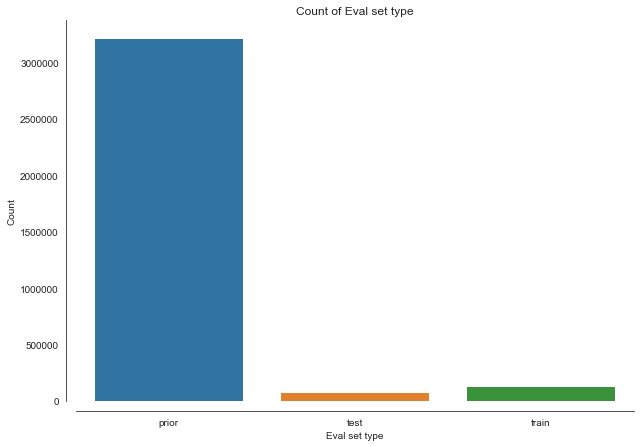

In [32]:
plt.figure(figsize = (10,7))
sns.countplot(x = 'eval_set', data = df_orders)
plt.xlabel ('Eval set type')
plt.ylabel ('Count')
plt.title ('Count of Eval set type')
sns.despine(offset=10)
plt.show()

'Eval set' type - dataset is categorized into prior, train and test. 

### 2.1.2 Orders by day of the week

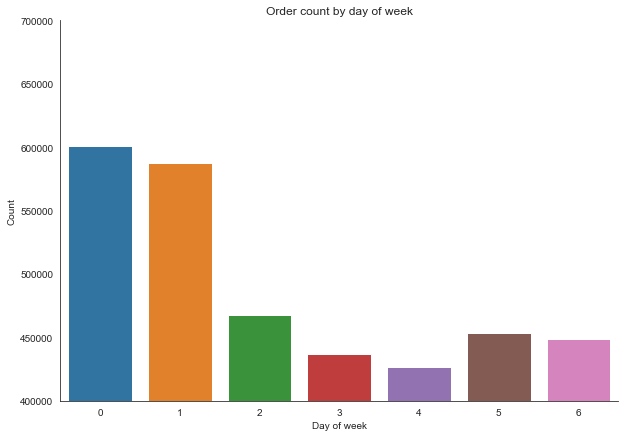

In [33]:
plt.figure(figsize = (10,7))
sns.countplot(x = 'order_dow', data = df_orders)
plt.xlabel ('Day of week')
plt.ylabel ('Count')
plt.ylim(400000,700000)
plt.title ('Order count by day of week')
sns.despine()#offset=10)
plt.show()

### 2.1.3 Orders by the hour of the day

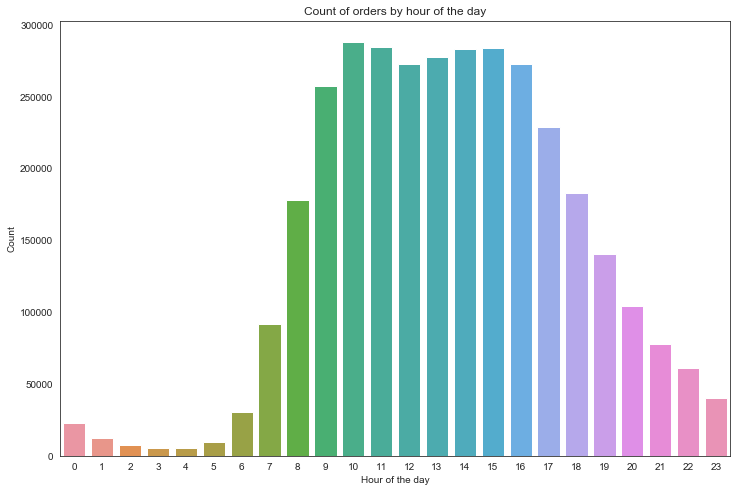

In [34]:
plt.figure(figsize = (12,8))
sns.countplot(x = 'order_hour_of_day', data = df_orders)
plt.xlabel ('Hour of the day')
plt.ylabel ('Count')
plt.title ('Count of orders by hour of the day')
plt.show()

It is evident from the bar graph above that most orders are placed between 8 am and 8 pm.<br/>
The least number of orders are placed between midnight and 6 am.

### 2.1.4 Reordering frequency 

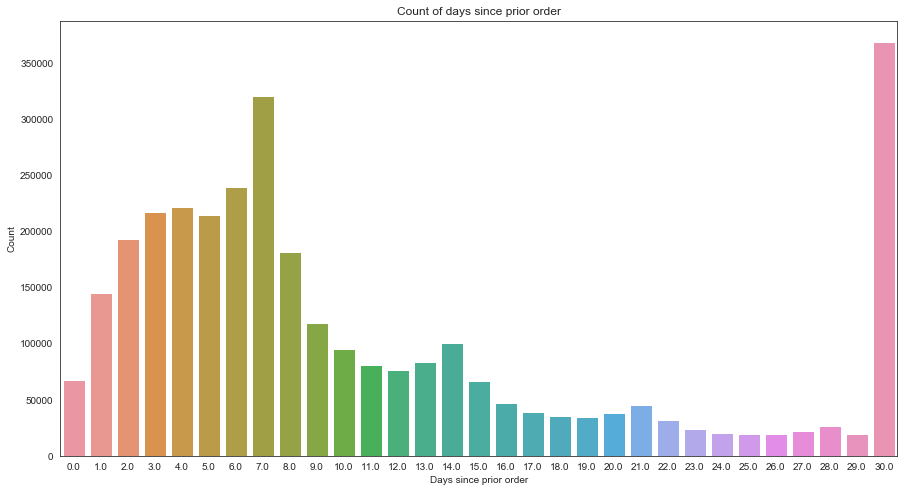

In [35]:
plt.figure(figsize = (15,8))
sns.countplot(x = 'days_since_prior_order', data = df_orders)
plt.xlabel ('Days since prior order')
plt.ylabel ('Count')
plt.title ('Count of days since prior order')
plt.show()

- Above graph shows interesting trends - although there are several orders within 4-7 days since the last order,
a significant number of orders are placed after 30 days of previous order. 

- This trend is interesting as the number of next orders decrease after the 7 day period until the 30th day.<br/>

- Also, above spikes in reorder on specific days could possibly because of a subscription service (reordering an item at user defined
frequency) - although such details are not available in the dataset.




### 2.1.5 Maximum number of orders(reorders) by a User

In [36]:
max_orders  = df_orders.groupby('user_id')['order_number'].max().reset_index()
max_orders.columns = ['user_id', 'order_count']
max_orders.head(3)

,user_id,order_count
0,1,11
1,2,15
2,3,13


### 2.1.6 Single orders and reorders

In [37]:
ord_reord_pie = df_order_products_prior[['product_id','reordered']].copy()
ord_reord_pie = ord_reord_pie.groupby(['reordered'])['product_id'].count().reset_index()
ord_reord_pie.rename(columns={"product_id": "count"}, inplace = True)
ord_reord_pie.replace([0,1], ['No-reorder','Reordered'], inplace = True)

In [38]:
ord_reord_pie

,reordered,count
0,No-reorder,13307953
1,Reordered,19126536


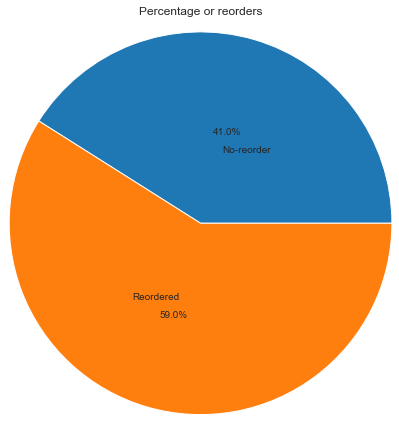

In [39]:
plt.pie('count', labels='reordered',autopct= '%1.1f%%', pctdistance=0.5,\
        labeldistance=0.4, radius=2.2, data=ord_reord_pie)
plt.title('Percentage or reorders', loc = 'center', pad = 100)
plt.show()

**59% of all the products in the dataset are reordered**

There is no description of day of week and associated numerals - it is assumed that 0 corresponds to Saturday and
1 corresponds to Sunday (intuitively, most orders are placed on these two days)

Above plot shows that most orders (600000 orders on Saturday and about 575000 orders on Sunday) are on the weekends
in comparison with weekday orders 

In [40]:
df_orders['user_id'].value_counts()

26086     100
120897    100
122476    100
31118     100
1868      100
138283    100
24609     100
115423    100
157667    100
24562     100
143099    100
170771    100
170746    100
24531     100
203027    100
143118    100
5296      100
143121    100
203020    100
91957     100
42711     100
149567    100
57367     100
57130     100
190983    100
24659     100
24766     100
102666    100
198217    100
190887    100
         ... 
74044       4
192359      4
74136       4
74138       4
74185       4
160523      4
22399       4
74214       4
160529      4
160533      4
160535      4
22409       4
192378      4
160542      4
160545      4
74189       4
160552      4
74146       4
192371      4
74181       4
192369      4
74179       4
74177       4
74175       4
160558      4
74171       4
160560      4
160570      4
74147       4
127633      4
Name: user_id, Length: 206209, dtype: int64

In [41]:
df_orders['days_since_prior_order'].value_counts()

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64

In [42]:
df_orders.loc[df_orders['days_since_prior_order'] == 0].count()

order_id                  67755
user_id                   67755
eval_set                  67755
order_number              67755
order_dow                 67755
order_hour_of_day         67755
days_since_prior_order    67755
dtype: int64

In [43]:
df_orders.loc[df_orders['days_since_prior_order'].isna()].count()

order_id                  206209
user_id                   206209
eval_set                  206209
order_number              206209
order_dow                 206209
order_hour_of_day         206209
days_since_prior_order         0
dtype: int64

Number of orders for which there were no prior orders = 67755
To decide whether to drop these rows from original dataframe

In [44]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [45]:
df_order_products_prior['order_id'].count()

32434489

In [46]:
df_order_products_prior['product_id'].count()

32434489

In [47]:
df_products['product_id'].count()

49688

In [48]:
df_dept['department_id'].count()

21

### 3. Merging tables

The following dataframes are merged on left join with df_order_products_prior

>- df_order_products<br/>
>- df_products<br/>
>- df_aisles<br/>
>- df_departments

In [49]:
df_order_products_merged = pd.merge(df_order_products_prior, df_products, how = 'left', on = 'product_id')
df_order_products_merged = pd.merge(df_order_products_merged, df_aisles, how = 'left', on = 'aisle_id')
df_order_products_merged = pd.merge(df_order_products_merged, df_dept, how = 'left', on = 'department_id')

df_order_products_merged.head(5)
gc.collect()

14716

In [50]:
df_order_products_merged.isna().sum().sum()

0

### Reordered products - analysis

**By filtering the reordered products from the dataset, we will analyse the products that were reordered**

In [51]:
df_reordered = df_order_products_merged.loc[df_order_products_merged['reordered'] == 1]
df_reordered.head(5)
gc.collect()

0

(0.0, 6468745.5, -0.5, 20.5)

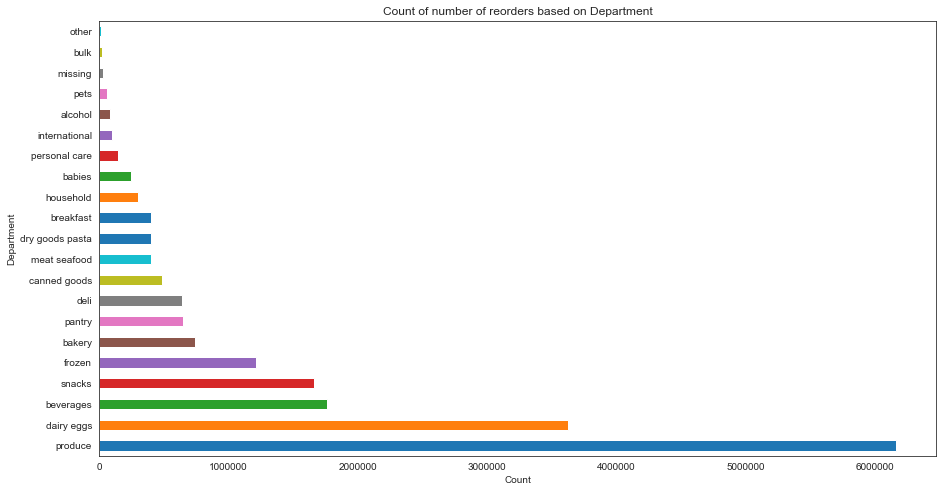

In [52]:
ax1 = df_reordered['department'].value_counts().plot(kind='barh',
                                    figsize=(15,8),
                                    title="Count of number of reorders based on Department")
ax1.set_xlabel("Count")
ax1.set_ylabel("Department")
plt.axis('on')

Most reorders are from the produce department, followed by dairy eggs and beverages.<br/>
Let us inspect the products which were reordered the most

### Top reordered products

Text(0, 0.5, 'Number of reorders')

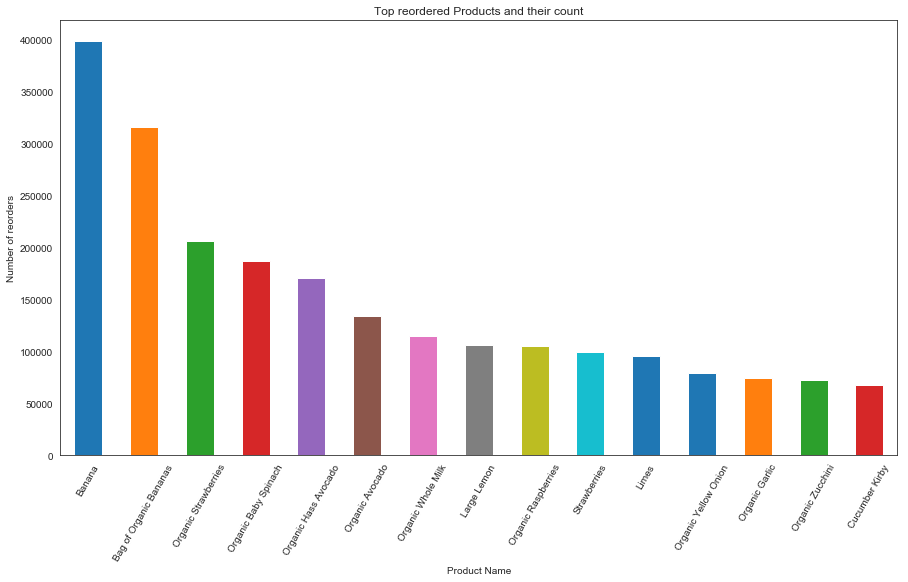

In [53]:
# reord_products = df_reordered['product_name'].value_counts().reset_index()
# reord_products.columns = ['product_name', 'count']
# top_reord_products = reord_products.head(15)
# top_reord_products

df_reordered['product_name'].value_counts().head(15).plot(kind = 'bar', figsize=(15,8),
                                    title="Top reordered Products and their count")
plt.xticks(rotation = 60)
plt.xlabel('Product Name') 
plt.ylabel('Number of reorders')


In [54]:
# plt.figure(figsize = (15,8))
# sns.barplot(top_reord_products['product_name'],top_reord_products['count'] )
# plt.xlabel('Product Name')
# plt.xticks(rotation = 60)
# plt.ylabel('Number of reorders')
# plt.title ('Top reordered Products and their count')
# plt.show()

### Reordering by aisle name

In [55]:
df_reordered_aisle = df_reordered['aisle'].value_counts().reset_index()
df_reordered_aisle.columns =  ['Aisle name', 'count']
df_reordered_aisle_top = df_reordered_aisle.head(15)
df_reordered_aisle_top

,Aisle name,count
0,fresh fruits,2615469
1,fresh vegetables,2032172
2,packaged vegetables fruits,1127177
3,yogurt,997018
4,milk,696264
5,water seltzer sparkling water,613977
6,packaged cheese,573383
7,soy lactosefree,442023
8,chips pretzels,425387
9,bread,391937


Above table shows the list of top items in a reorder, most orders being fruits or vegetables

Text(0, 0.5, 'Number of reorders')

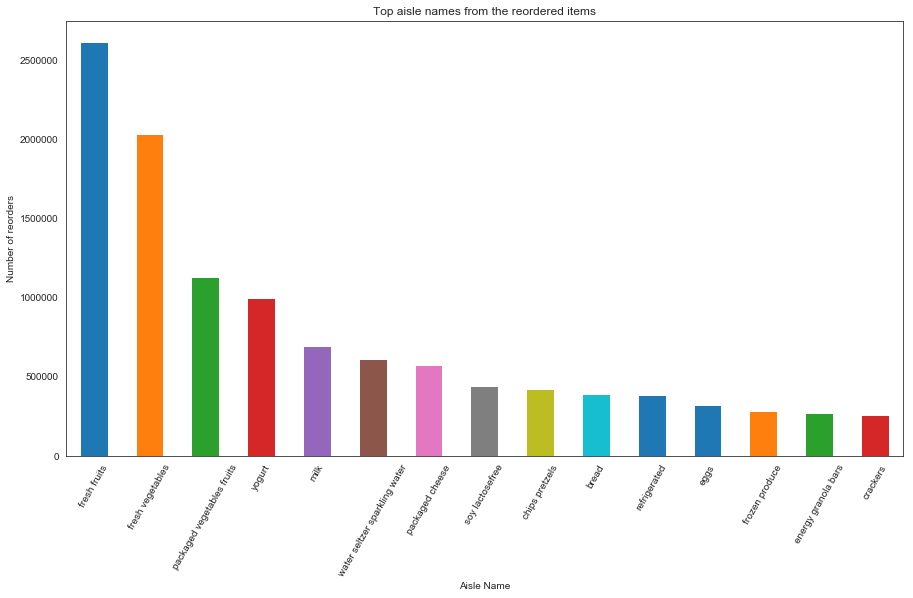

In [56]:
## Seaborn plot keeping kernel busy
# plt.figure(figsize = (15,8))
# sns.barplot(df_reordered_aisle_top['Aisle name'],df_reordered_aisle_top['count'] )
# plt.xlabel('Aisle name')
# plt.xticks(rotation = 60)
# plt.ylabel('Number of occurences')
# plt.title ('Top aisle names from the reordered items')
# plt.show()


####################
#Working plot - reuse
#####################
df_reordered.aisle.value_counts().head(15).plot(kind = 'bar', figsize=(15,8),
                                    title="Top aisle names from the reordered items")
plt.xticks(rotation = 60)
plt.xlabel('Aisle Name') 
plt.ylabel('Number of reorders')



#######################
# Fix the below plot - not plotting properly
#######################
# plt.figure(figsize = (15,8))
# sns.barplot (df_reordered_aisle_top['Aisle name'], df_reordered_aisle_top['count'])
# plt.xlabel('Aisle Name')
# plt.ylabel ('Number of reorders')
# # plt.xlim((0,39))
# plt.title('Top aisle names from the reordered items')
# plt.show()



### Most reorders are observed in Fresh fruits, fresh vegetables an dairy products

### Number of products in the reorders

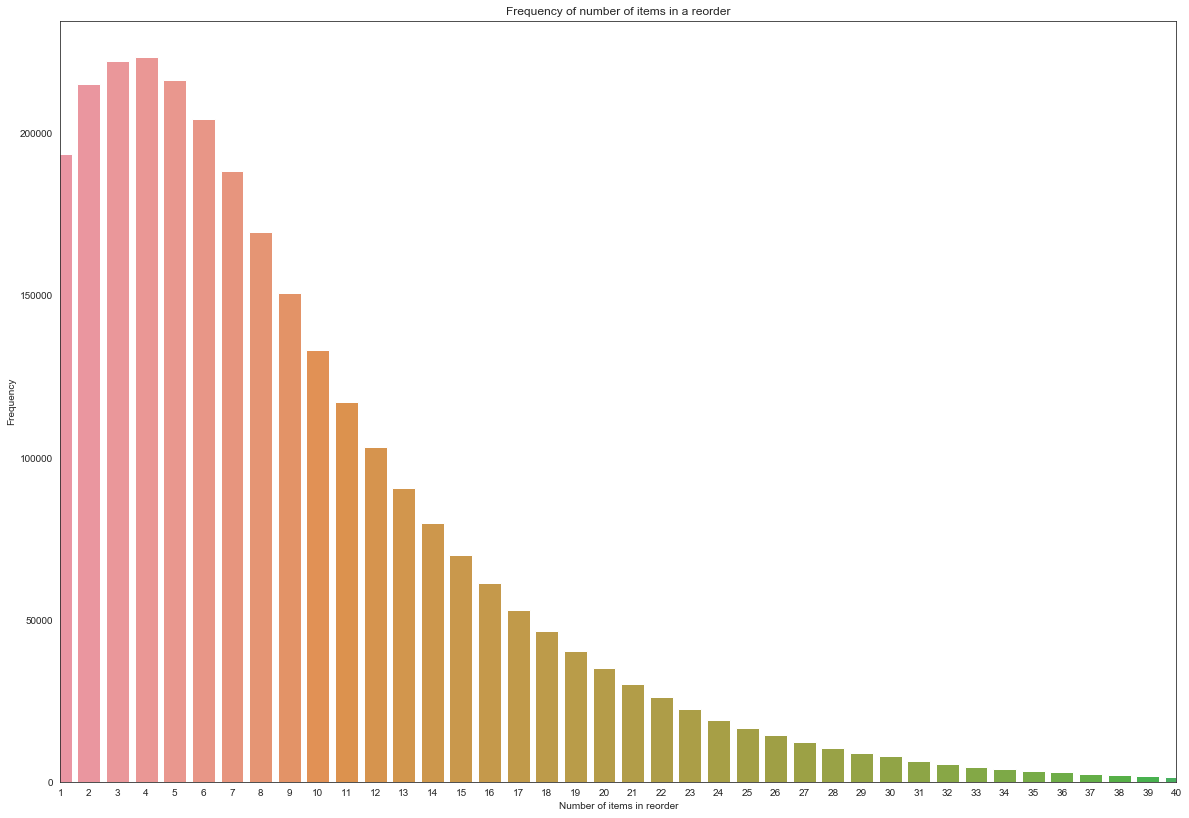

In [57]:
df_reordered_noofitems = df_reordered.groupby(['order_id'])['add_to_cart_order'].max().reset_index()
grouped = df_reordered_noofitems['add_to_cart_order'].value_counts()

plt.figure(figsize = (20,14))
sns.barplot (grouped.index, grouped.values)
plt.xlabel('Number of items in reorder')
plt.ylabel ('Frequency')
plt.xlim((0,39))
plt.title('Frequency of number of items in a reorder')
plt.show()

From the above bar graph, most reorders have between 1 and 8 products.<br/>
Maximum number of reorders were with 4 products in the order.<br/> 
*Note : The number of items were limited to 40 for better visualization of graph*

### Organic products in reorders

In [58]:
df_reordered.head(3)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry


In [59]:
df_organic_reord = df_reordered[df_reordered['product_name'].str.contains("Organic")]
df_organic_reord.shape

(6508236, 9)

In [60]:
df_organic_reord = df_organic_reord['product_name'].value_counts().reset_index()
df_organic_reord.columns = ['product name', 'count']
df_organic_reord_top  = df_organic_reord.head(15)
df_organic_reord_top

,product name,count
0,Bag of Organic Bananas,315913
1,Organic Strawberries,205845
2,Organic Baby Spinach,186884
3,Organic Hass Avocado,170131
4,Organic Avocado,134044
5,Organic Whole Milk,114510
6,Organic Raspberries,105409
7,Organic Yellow Onion,79072
8,Organic Garlic,74663
9,Organic Zucchini,72165


In [61]:
##########################
#Seaborn plot not working
##########################

# plt.figure(figsize = (15,8))
# sns.barplot(df_organic_reord_top['product name'],df_reordered_aisle_top['count'] )
# plt.xlabel('Product name')
# plt.xticks(rotation = 60)
# plt.ylabel('Frequency Count')
# plt.title ('Top Organic products in reordered items')
# plt.show()


**Bananas, strawberries, spinach, Avocado top the list of top organic items in a reorder.**

### Reorder Ratio by department

In [62]:
reorder_ratio_dept = df_order_products_merged.groupby('department')['reordered'].mean().reset_index()
reorder_ratio_dept.columns = ['department', 'reorder_ratio']
reorder_ratio_dept.sort_values(by='reorder_ratio', ascending=False)

,department,reorder_ratio
7,dairy eggs,0.669969
3,beverages,0.653460
19,produce,0.649913
2,bakery,0.628141
8,deli,0.607719
18,pets,0.601285
1,babies,0.578971
5,bulk,0.577040
20,snacks,0.574180
0,alcohol,0.569924


### Reorder Ratio by Aisle

In [63]:
reorder_ratio_aisle = df_order_products_merged.groupby('aisle')['reordered'].mean().reset_index()
reorder_ratio_aisle.columns = ['aisle', 'reorder_ratio']
reorder_ratio_aisle.sort_values(by='reorder_ratio', ascending=False)

,aisle,reorder_ratio
83,milk,0.781428
131,water seltzer sparkling water,0.729593
50,fresh fruits,0.718104
41,eggs,0.705366
119,soy lactosefree,0.692551
96,packaged produce,0.690734
133,yogurt,0.686489
33,cream,0.685046
11,bread,0.670168
110,refrigerated,0.663302


### Frequency(of ordering) of top reordered products
 

In [64]:
df_orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [65]:
df_orders.shape

(3421083, 7)

In [66]:
df_reordered.shape

(19126536, 9)

### Merging the original `df_orders` dataframe with the earlier merged `df_order_products_merged`

In [67]:
order_merged = pd.merge (df_order_products_merged, df_orders, how = 'inner', on = 'order_id')
order_merged.head(3)
gc.collect()

19342

In [68]:
##delete cell
df_order_products_merged.head(2)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce


In [69]:
##Delete cell

df_orders.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [70]:
top_reord_products  = order_merged.groupby('product_name')['reordered'].mean().reset_index()
top_reord_products.sort_values(by = 'reordered', inplace = True, ascending = False)
top_reord_products.head(2)

,product_name,reordered
37380,Raw Veggie Wrappers,0.941176
39871,Serenity Ultimate Extrema Overnight Pads,0.931034


In [71]:
top_reord_products_ratio = top_reord_products.head(10)

Raw Veggie Wrappers, Serenity Ultimate Extreme Overnight Pads, Organge Energy shots top the list of
top products with highest reorder ratio (average reorders)

In [72]:
order_merged.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


## Exploring User level and product level orders

### Number of reorders per customer 

In [73]:
cust_orders = order_merged.groupby('user_id')['order_number'].max().reset_index()
cust_orders.columns = ['user_id', 'Max_no_of_orders']
cust_orders.head()

,user_id,Max_no_of_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


### Reorder ratio of each customer
#### How frequently a customer reordered the products

In [74]:
reorder_ratio = order_merged.groupby('user_id')['reordered'].mean().reset_index()
reorder_ratio.columns = ['user_id', 'user_reorder_ratio']

reorder_ratio.head()

,user_id,user_reorder_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


### Merging both of the above dataframes

In [75]:
max_order_reord = pd.merge(cust_orders, reorder_ratio, how = 'inner', on = 'user_id')
gc.collect()

42

In [76]:
max_order_reord.head()

,user_id,Max_no_of_orders,user_reorder_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


### Number of reorders for each product

In [77]:
product_reord_count = order_merged.groupby('product_id')['order_id'].count().reset_index()
product_reord_count.columns = ['product_id', 'product_purchase_count']
product_reord_count.head()

,product_id,product_purchase_count
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


### Probability of a product to be reordered

In [78]:
prod_reord_prob = order_merged.groupby('product_id')['reordered'].mean().reset_index()
prod_reord_prob.columns = ['product_id', 'prod_reord_probability']
prod_reord_prob.head()

,product_id,prod_reord_probability
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


### Merging both of the above dataframes

In [79]:
prod_freq_prob = pd.merge(product_reord_count, prod_reord_prob, how = 'inner', on = 'product_id')
gc.collect()

42

In [80]:
prod_freq_prob.head()

,product_id,product_purchase_count,prod_reord_probability
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [81]:
prod_freq_prob.isna().sum()

product_id                0
product_purchase_count    0
prod_reord_probability    0
dtype: int64

____________________

____________________

### USER - PRODUCT FEATURES

### How many times user bought a product

In [82]:
### N (dividend)
user_prod_freq = order_merged.groupby(['user_id', 'product_id'])['order_id'].count().reset_index() #remove reset_index
user_prod_freq.columns = ['user_id', 'product_id', 'up_purchase_count']
user_prod_freq.head()

,user_id,product_id,up_purchase_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


### Maximum purchases by a user

In [83]:
### D (divisor)
user_max_reord = order_merged.groupby('user_id')[['order_number']].max().reset_index()
user_max_reord.columns = ['user_id', 'uid_max_order_count']
user_max_reord.head()

,user_id,uid_max_order_count
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [84]:
print('The number of rows in the user_max_reord dataframe: {}\n\
The number of unique user_id values: {}'.format(len(user_max_reord), user_max_reord['user_id'].nunique()))

The number of rows in the user_max_reord dataframe: 206209
The number of unique user_id values: 206209


### Finding out when the user bought the product for the first time


In [85]:
user_first_prod = order_merged.groupby(['user_id', 'product_id'])['order_number'].min().reset_index()
user_first_prod.columns = ['user_id', 'product_id', 'up_order_count']
user_first_prod.head()

,user_id,product_id,up_order_count
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [86]:
print('The number of rows in user_first_prod dataframe: {}\n\
The number of unique user_id values: {}\n\
The number of unique product_id values: {}'.format(len(user_first_prod), user_first_prod['user_id'].nunique(),\
                                                  user_first_prod['product_id'].nunique()))

The number of rows in user_first_prod dataframe: 13307953
The number of unique user_id values: 206209
The number of unique product_id values: 49677


### Merge above dataframes (max. purchases by user and min. number of times product was bought)

As the above dataframe has more rows and repeated `user_id/product_id`, we consider the above dataframe as the left dataframe while merging with `user_max_reord`

In [87]:
user_prod_max_orders = pd.merge(user_first_prod, user_max_reord, how = 'left', on = 'user_id')
gc.collect()

42

In [88]:
user_prod_max_orders.head()

,user_id,product_id,up_order_count,uid_max_order_count
0,1,196,1,10
1,1,10258,2,10
2,1,10326,5,10
3,1,12427,1,10
4,1,13032,2,10


### Total orders placed since the user's first order of a product

We add another column to the above dataframe which is the value difference between `up_order_count` and 
`uid_max_order_count`

In [89]:
user_prod_max_orders['ord_count_since_first_order'] = user_prod_max_orders['uid_max_order_count']- \
                                                            user_prod_max_orders ['up_order_count'] +1

user_prod_max_orders.head(3)

,user_id,product_id,up_order_count,uid_max_order_count,ord_count_since_first_order
0,1,196,1,10,10
1,1,10258,2,10,9
2,1,10326,5,10,6


### Merging `user_prod_freq` (left) and `user_prod_max_orders` dataframes on `'user_id` and `product_id`

In [90]:
user_prod_freq.head()

,user_id,product_id,up_purchase_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [91]:
print('The number of rows in the user_prod_freq dataframe: {}\n\
The number of unique user_id values: {}\n\
The number of unique product_id values: {}'.format(len(user_prod_freq), user_prod_freq['user_id'].nunique(),\
                                                  user_prod_freq['product_id'].nunique()))

The number of rows in the user_prod_freq dataframe: 13307953
The number of unique user_id values: 206209
The number of unique product_id values: 49677


In [92]:
user_prod_max_orders.head()

,user_id,product_id,up_order_count,uid_max_order_count,ord_count_since_first_order
0,1,196,1,10,10
1,1,10258,2,10,9
2,1,10326,5,10,6
3,1,12427,1,10,10
4,1,13032,2,10,9


In [93]:
print('The number of rows in the user_prod_max_orders dataframe: {}\n\
The number of unique user_id values: {}\n\
The number of unique product_id values: {}'.format(len(user_prod_max_orders), user_prod_max_orders['user_id'].\
                                                   nunique(),user_prod_max_orders['product_id'].nunique()))

The number of rows in the user_prod_max_orders dataframe: 13307953
The number of unique user_id values: 206209
The number of unique product_id values: 49677


In [94]:
user_prod_ratio = pd.merge(user_prod_freq, user_prod_max_orders, how = 'left', on = ['user_id', 'product_id'])
gc.collect()

user_prod_ratio.head()

,user_id,product_id,up_purchase_count,up_order_count,uid_max_order_count,ord_count_since_first_order
0,1,196,10,1,10,10
1,1,10258,9,2,10,9
2,1,10326,1,5,10,6
3,1,12427,10,1,10,10
4,1,13032,3,2,10,9


In [95]:
user_prod_ratio['up_reorder_ratio'] = user_prod_ratio['up_purchase_count']/user_prod_ratio['ord_count_since_first_order']

user_prod_ratio.head()

,user_id,product_id,up_purchase_count,up_order_count,uid_max_order_count,ord_count_since_first_order,up_reorder_ratio
0,1,196,10,1,10,10,1.000000
1,1,10258,9,2,10,9,1.000000
2,1,10326,1,5,10,6,0.166667
3,1,12427,10,1,10,10,1.000000
4,1,13032,3,2,10,9,0.333333


In [96]:
user_prod_ratio_featureset = user_prod_ratio[['user_id', 'product_id', 'up_reorder_ratio']]
user_prod_ratio_featureset.head()

,user_id,product_id,up_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [97]:
print('The number of rows in the user_prod_ratio_featureset dataframe: {}\n\
The number of unique user_id values: {}\n\
The number of unique product_id values: {}'.format(len(user_prod_ratio_featureset), user_prod_ratio_featureset['user_id'].\
                                                   nunique(),user_prod_ratio_featureset['product_id'].nunique()))

The number of rows in the user_prod_ratio_featureset dataframe: 13307953
The number of unique user_id values: 206209
The number of unique product_id values: 49677


### Merging `user_prod_ratio_featureset` dataframe with `user_prod_freq`

In [98]:
user_prod_freq.head()

,user_id,product_id,up_purchase_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [99]:
print('The number of rows in the user_prod_freq dataframe: {}\n\
The number of unique user_id values: {}\n\
The number of unique product_id values: {}'.format(len(user_prod_freq), user_prod_freq['user_id'].\
                                                   nunique(),user_prod_freq['product_id'].nunique()))

The number of rows in the user_prod_freq dataframe: 13307953
The number of unique user_id values: 206209
The number of unique product_id values: 49677


In [100]:
user_product_purch_reord = pd.merge(user_prod_freq, user_prod_ratio_featureset, how = 'inner', on =\
                                   ['user_id', 'product_id'])
gc.collect()

user_product_purch_reord.head()

,user_id,product_id,up_purchase_count,up_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


_____________________________________
_____________________________________

### Number of times a User bought a product out of 5 most recent orders

To compute this, we keep the last five orders for eaach user and get how many times a product was bought in those
last 5 purchases. Doing this will give us a rich dataset of reordering users (of atleast 5 reorders) and the number
of times a product was purchased in the last 5 orders.


We use the `.transform()` method to fill in the order numbers in reverse (i.e., incase a user has made 10 orders,we will consider the last(latest) 5 orders and the product ids related to those orders. So the order numbering will
be reversed to filter out the most 5 recent orders. Using `.transform()` method will help us retain the size of the dataset and the aggregated values are updated in the assigned column. 


>**Transformation**<br/>
>While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine. For such a transformation, the output is the same shape as the input.[ref_link](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb)



In [101]:
order_merged['order_number_reversed'] = order_merged.groupby('user_id')['order_number'].transform(max)\
                                                                                    - order_merged['order_number'] +1 
order_merged.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_reversed
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,6
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,6
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,6
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,6
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,6


### Filtering to retain only 5 most recent orders

In [102]:
order_merged_5 = order_merged.loc[order_merged['order_number_reversed'] <= 5]
gc.collect()
order_merged_5.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_reversed
56,6,40462,1,0,Cleanse,31,7,refrigerated,beverages,22352,prior,4,1,12,30.0,5
57,6,15873,2,0,Dryer Sheets Geranium Scent,75,17,laundry,household,22352,prior,4,1,12,30.0,5
58,6,41897,3,0,Clean Day Lavender Scent Room Freshener Spray,101,17,air fresheners candles,household,22352,prior,4,1,12,30.0,5
59,7,34050,1,0,Orange Juice,31,7,refrigerated,beverages,142903,prior,11,2,14,30.0,2
60,7,46802,2,0,Pineapple Chunks,116,1,frozen produce,frozen,142903,prior,11,2,14,30.0,2


Grouping the dataframe to show the `user_id`, `product_id` and `order_id` (number of times a product was ordered in the 5 recent orders)

In [103]:
user_prod_5 = order_merged_5.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
user_prod_5.columns = ['user_id', 'product_id', 'up_order_count_5']
user_prod_5.head(10)

,user_id,product_id,up_order_count_5
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
5,1,35951,1
6,1,38928,1
7,1,39657,1
8,1,46149,3
9,1,49235,2


In [104]:
print(len(user_prod_5),
user_prod_5.product_id.nunique(),\
      user_prod_5.user_id.nunique())

6714245 48808 206209


### Joining dataframes `user_prod_5` and `user_product_purch_reord`

In [105]:
user_prod_freq = pd.merge(user_prod_freq, user_prod_5, how = 'left', on = ['user_id', 'product_id'])

gc.collect()

user_prod_freq.head(5)

,user_id,product_id,up_purchase_count,up_order_count_5
0,1,196,10,5.0
1,1,10258,9,5.0
2,1,10326,1,NaN
3,1,12427,10,5.0
4,1,13032,3,2.0


In [106]:
user_prod_freq.isna().any()

user_id              False
product_id           False
up_purchase_count    False
up_order_count_5      True
dtype: bool

**Imputing NaN Values in `up_order_count_5`<br/>**
We arrived at NaN values in `up_order_count_5` column possibly because there were no specific product reorders in the
last 5 (recent) orders.<br/>
NaNs will be replaced with 0 

In [107]:
user_prod_freq['up_order_count_5'] = user_prod_freq['up_order_count_5'].fillna(0)
user_prod_freq.head(5)

,user_id,product_id,up_purchase_count,up_order_count_5
0,1,196,10,5.0
1,1,10258,9,5.0
2,1,10326,1,0.0
3,1,12427,10,5.0
4,1,13032,3,2.0


### Merging the User, Product and USER/PRODUCT dataframes created above

In [108]:
dataset = pd.merge(user_prod_freq, max_order_reord, how = 'left', on = 'user_id')
dataset.head(3)

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio
0,1,196,10,5.0,10,0.694915
1,1,10258,9,5.0,10,0.694915
2,1,10326,1,0.0,10,0.694915


Merging above dataset with `product_freq_prob`

In [109]:
dataset = pd.merge(dataset, prod_freq_prob, how = 'left', on = 'product_id')

gc.collect()

dataset.head(5)

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability
0,1,196,10,5.0,10,0.694915,35791,0.776480
1,1,10258,9,5.0,10,0.694915,1946,0.713772
2,1,10326,1,0.0,10,0.694915,5526,0.652009
3,1,12427,10,5.0,10,0.694915,6476,0.740735
4,1,13032,3,2.0,10,0.694915,3751,0.657158


We have user based and product based metrics available in the above dataframe:
1. Count of each product purchase for each user (`up_purchase_count`)
2. Reorder probability (Ratio of number of times user bought a product to the total orders placed since first order of product)(`up_reorder_ratio`)
3. Number of times a product was reordered in the last 5 orders (`up_order_count_5`)
4. Maximum number of orders for each user (`Max_no_of_orders`)
5. How frequently a user reordered the products (user_reorder_ratio)
6. Number of reorders for each Product (`product_purchase_count`)
7. Probability of product to be reordered (`prod_reord_probability`)

### Deleting unused dataframes to create computing space

In [110]:
del max_order_reord, prod_reord_prob, user_prod_freq

gc.collect()

0

### Merging the `dataset` dataframe with `df_orders` to create our features

To retain all the above values, we will do a left join with `df_orders` to include order_id

Taking the test and train values for merging the dataframes

In [111]:
future_orders = df_orders.loc[df_orders['eval_set']!='prior', ['user_id', 'eval_set', 'order_id'] ]
future_orders.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [112]:
dataset = pd.merge(dataset, future_orders, on='user_id', how='left')
dataset.head(10)

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability,eval_set,order_id
0,1,196,10,5.0,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,5.0,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.0,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,5.0,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,2.0,10,0.694915,3751,0.657158,train,1187899
5,1,13176,2,0.0,10,0.694915,379450,0.832555,train,1187899
6,1,14084,1,0.0,10,0.694915,15935,0.810982,train,1187899
7,1,17122,1,0.0,10,0.694915,13880,0.675576,train,1187899
8,1,25133,8,5.0,10,0.694915,6196,0.740155,train,1187899
9,1,26088,2,0.0,10,0.694915,2523,0.539041,train,1187899


To arrive at the train and test dataset with the predictor variables, we
1. Split the above dataset dataframe into train and test as per their labels in 'eval_set'
2. Merge `dataset` dataframe with `order_products_train` using `product_id` and `order_id` as primary keys

In [113]:
train_dataset = dataset[dataset['eval_set']=='train']

In [114]:
train_dataset = pd.merge(train_dataset,df_order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
train_dataset.head()

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability,eval_set,order_id,reordered
0,1,196,10,5.0,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,5.0,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.0,10,0.694915,5526,0.652009,train,1187899,NaN
3,1,12427,10,5.0,10,0.694915,6476,0.740735,train,1187899,NaN
4,1,13032,3,2.0,10,0.694915,3751,0.657158,train,1187899,1.0


Imputing NaN values in `reordered` column with 0

In [115]:
train_dataset['reordered'] = train_dataset['reordered'].fillna(0)
train_dataset.head()

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability,eval_set,order_id,reordered
0,1,196,10,5.0,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,5.0,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.0,10,0.694915,5526,0.652009,train,1187899,0.0
3,1,12427,10,5.0,10,0.694915,6476,0.740735,train,1187899,0.0
4,1,13032,3,2.0,10,0.694915,3751,0.657158,train,1187899,1.0


### Dropping columns not necessary for our model `eval_set` and `order_id` (as we are using `user_id` and `product_id` features)

In [116]:
train_dataset = train_dataset.drop(['eval_set', 'order_id'], axis =1)
train_dataset.head(5)

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability,reordered
0,1,196,10,5.0,10,0.694915,35791,0.776480,1.0
1,1,10258,9,5.0,10,0.694915,1946,0.713772,1.0
2,1,10326,1,0.0,10,0.694915,5526,0.652009,0.0
3,1,12427,10,5.0,10,0.694915,6476,0.740735,0.0
4,1,13032,3,2.0,10,0.694915,3751,0.657158,1.0


In [117]:
train_dataset = train_dataset.set_index(['user_id', 'product_id'])
train_dataset.head()

up_purchase_count  up_order_count_5  Max_no_of_orders  \
user_id product_id                                                          
1       196                        10               5.0                10   
        10258                       9               5.0                10   
        10326                       1               0.0                10   
        12427                      10               5.0                10   
        13032                       3               2.0                10   

                    user_reorder_ratio  product_purchase_count  \
user_id product_id                                               
1       196                   0.694915                   35791   
        10258                 0.694915                    1946   
        10326                 0.694915                    5526   
        12427                 0.694915                    6476   
        13032                 0.694915                    3751   

                    prod_reord_probability  reordered  
user_id product_id                                     
1       196                       0.776480        1.0  
        10258                     0.713772        1.0  
        10326                     0.652009        0.0  
        12427                     0.740735        0.0  
        13032                     0.657158        1.0

### Creating test dataframe

In [118]:
test_dataset = dataset[dataset['eval_set']=='test']
test_dataset.head()

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability,eval_set,order_id
120,3,248,1,0.0,12,0.625,6371,0.400251,test,2774568
121,3,1005,1,1.0,12,0.625,463,0.440605,test,2774568
122,3,1819,3,0.0,12,0.625,2424,0.492162,test,2774568
123,3,7503,1,0.0,12,0.625,12474,0.553551,test,2774568
124,3,8021,1,0.0,12,0.625,27864,0.591157,test,2774568


In [119]:
test_dataset = test_dataset.drop(['eval_set', 'order_id'], axis =1)
test_dataset.head(5)

,user_id,product_id,up_purchase_count,up_order_count_5,Max_no_of_orders,user_reorder_ratio,product_purchase_count,prod_reord_probability
120,3,248,1,0.0,12,0.625,6371,0.400251
121,3,1005,1,1.0,12,0.625,463,0.440605
122,3,1819,3,0.0,12,0.625,2424,0.492162
123,3,7503,1,0.0,12,0.625,12474,0.553551
124,3,8021,1,0.0,12,0.625,27864,0.591157


In [120]:
test_dataset = test_dataset.set_index(['user_id', 'product_id'])
test_dataset.head()

up_purchase_count  up_order_count_5  Max_no_of_orders  \
user_id product_id                                                          
3       248                         1               0.0                12   
        1005                        1               1.0                12   
        1819                        3               0.0                12   
        7503                        1               0.0                12   
        8021                        1               0.0                12   

                    user_reorder_ratio  product_purchase_count  \
user_id product_id                                               
3       248                      0.625                    6371   
        1005                     0.625                     463   
        1819                     0.625                    2424   
        7503                     0.625                   12474   
        8021                     0.625                   27864   

                    prod_reord_probability  
user_id product_id                          
3       248                       0.400251  
        1005                      0.440605  
        1819                      0.492162  
        7503                      0.553551  
        8021                      0.591157

###################################################################################################

### Machine Learning Modeling

#### Feature Engineering and modeling using XGBoost classifier
#### Iteration 1

In [121]:
# original code (with most feature importance) - importance strongly tilted towards 'up_order_count_5'
X_train, y_train = train_dataset.drop('reordered', axis =1), train_dataset['reordered']

# #updated code to check change in feature importance iteration 3 (importance strongly tilted towards one feature)
# X_train, y_train = train_dataset.drop(['reordered', 'product_purchase_count'], axis =1), train_dataset['reordered']


In [122]:
xgb = XGBClassifier(random_state =42)

In [123]:
%%time
xgb.fit(X_train, y_train)

CPU times: user 18min 6s, sys: 4.75 s, total: 18min 10s
Wall time: 18min 12s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

                        importance
up_order_count_5          0.756224
prod_reord_probability    0.087629
up_purchase_count         0.075534
Max_no_of_orders          0.034268
product_purchase_count    0.027210
user_reorder_ratio        0.019134


110

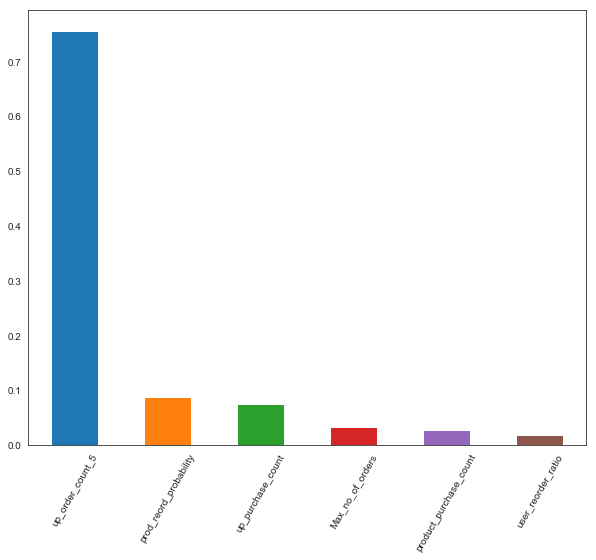

In [124]:
feature_importances_df = pd.DataFrame(xgb.feature_importances_, index = X_train.columns, \
                                      columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)


feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending = False)
plt.figure(figsize = (10,8))
feat_importances.plot(kind='bar')
plt.xticks(rotation=60)

gc.collect()

Alternatively, calculating f score (feature score/importance) based on how many times each feature is split on

In [127]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [128]:
test_pred1 = xgb.predict_proba(test_dataset)

In [129]:
test_pred1

array([[0.9693903 , 0.03060974],
       [0.92585367, 0.07414632],
       [0.93292034, 0.06707965],
       ...,
       [0.9849233 , 0.01507669],
       [0.9930041 , 0.00699592],
       [0.98554915, 0.01445085]], dtype=float32)

#### Feature Engineering - Iteration 2
#### Dropping the most important feature `up_order_count_5` to observe the change in feature importances.

`up_order_count_5` is the number of times a product was reordered in the last 5 orders. Intuitively, this feature
influences the next purchase for the user. Removing this feature might help in highlighting the other features which are otherwise of lesser in magnitude of importance (in comparison with the above feature)

In [130]:
#Updated feature set after checking feature importances and dropping additional columns
X_train2, y_train2 = train_dataset.drop(['reordered', 'up_order_count_5'], axis =1), train_dataset['reordered']

In [131]:
#### Fitting the model

xgb.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

                        importance
up_purchase_count         0.520784
Max_no_of_orders          0.226626
prod_reord_probability    0.191139
user_reorder_ratio        0.035879
product_purchase_count    0.025571


2464

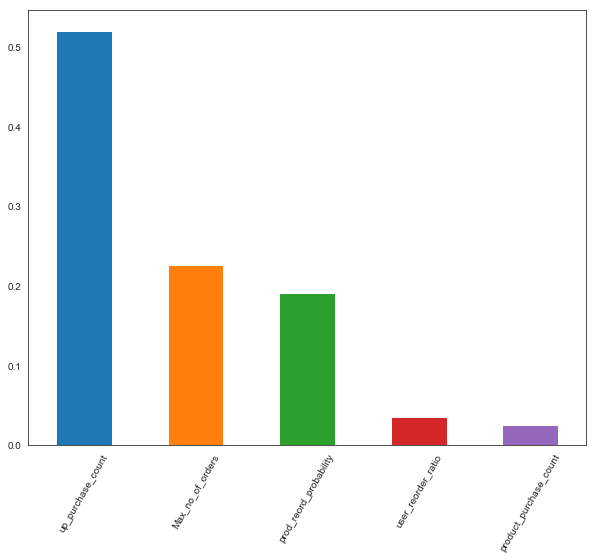

In [133]:
### Rechecking feature importances

feature_importances_df = pd.DataFrame(xgb.feature_importances_, index = X_train2.columns, \
                                      columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)


feat_importances = pd.Series(xgb.feature_importances_, index=X_train2.columns).sort_values(ascending = False)
plt.figure(figsize = (10,8))
feat_importances.plot(kind='bar')
plt.xticks(rotation=60)

gc.collect()

Dropping the most important feature earlier `up_order_count_5` changed the feature importance as above.

Retaining the above feature set for our final model

### Using GridSearchCV and Parameter tuning 

In [126]:
# params = {
#     'max_depth': [3,5,7],
#     'max_features': [3, 4, 5],
#     'n_estimators': [14, 16, 20]
# }

# grid = GridSearchCV(estimator = xgb, param_grid = params, cv = 5)
# grid.fit(X_train, y_train)

# print("The best parameters are: /n",  grid_search.best_params_)

# FEATURE IMPORTANCE

# labels = X_train.columns
# labels

# for feature in zip(labels, grid.best_estimator_.feature_importances_):
#          print(feature)

### Predicting NONE Reorders by creating the predictor variable from `prod_reord_probability`.
### Creating labels using the reorder ratio by rounding the values. Here `0` indicates no reorder and `1` indicates reorder


In [134]:
train_dataset['none_reordered'] = train_dataset['prod_reord_probability'].apply(lambda x: 0 if x <=0.5 else 1)

In [135]:
train_dataset.head(5)

up_purchase_count  up_order_count_5  Max_no_of_orders  \
user_id product_id                                                          
1       196                        10               5.0                10   
        10258                       9               5.0                10   
        10326                       1               0.0                10   
        12427                      10               5.0                10   
        13032                       3               2.0                10   

                    user_reorder_ratio  product_purchase_count  \
user_id product_id                                               
1       196                   0.694915                   35791   
        10258                 0.694915                    1946   
        10326                 0.694915                    5526   
        12427                 0.694915                    6476   
        13032                 0.694915                    3751   

                    prod_reord_probability  reordered  none_reordered  
user_id product_id                                                     
1       196                       0.776480        1.0               1  
        10258                     0.713772        1.0               1  
        10326                     0.652009        0.0               1  
        12427                     0.740735        0.0               1  
        13032                     0.657158        1.0               1

In [136]:
X_train_none, y_train_none = train_dataset.drop(['reordered', 'none_reordered', 'prod_reord_probability' ], axis =1),\
                                                                                train_dataset['none_reordered']

In [137]:
%%time
xgb.fit(X_train_none, y_train_none)

CPU times: user 14min 22s, sys: 1.72 s, total: 14min 24s
Wall time: 14min 22s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

                        importance
product_purchase_count    0.742157
up_purchase_count         0.161171
up_order_count_5          0.055514
Max_no_of_orders          0.035361
user_reorder_ratio        0.005798


2212

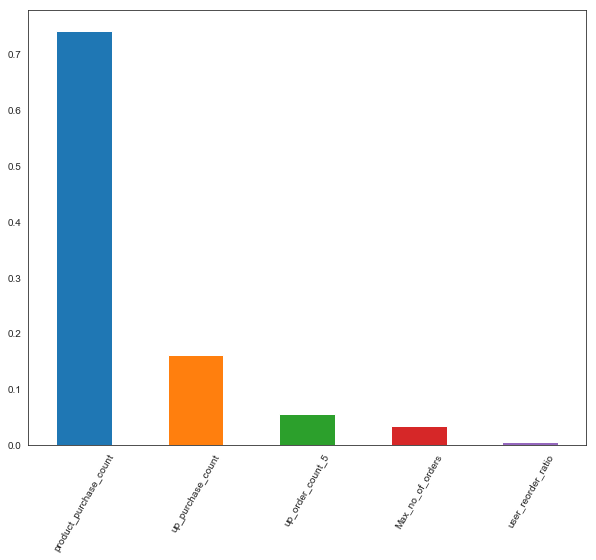

In [138]:
feature_importances_df = pd.DataFrame(xgb.feature_importances_, index = X_train_none.columns, \
                                      columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)


feat_importances = pd.Series(xgb.feature_importances_, index=X_train_none.columns).sort_values(ascending = False)
plt.figure(figsize = (10,8))
feat_importances.plot(kind='bar')
plt.xticks(rotation=60)

gc.collect()

In [152]:
# test_dataset_none = test_dataset.drop('prod_reord_probability', axis =1, inplace = True)
# test_dataset_none

test_dataset.head(3)

up_purchase_count  up_order_count_5  Max_no_of_orders  \
user_id product_id                                                          
3       248                         1               0.0                12   
        1005                        1               1.0                12   
        1819                        3               0.0                12   

                    user_reorder_ratio  product_purchase_count  
user_id product_id                                              
3       248                      0.625                    6371  
        1005                     0.625                     463  
        1819                     0.625                    2424

In [153]:
test_pred2 = xgb.predict_proba(test_dataset)
test_pred2

array([[0.36774898, 0.632251  ],
       [0.67628664, 0.32371336],
       [0.36191756, 0.63808244],
       ...,
       [0.41078585, 0.58921415],
       [0.74275124, 0.25724873],
       [0.4271465 , 0.5728535 ]], dtype=float32)